# **Waste Material Segregation for Improving Waste Management**

Tyler Wolfe

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [44]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [77]:
# Import essential libraries
import zipfile
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

Load the dataset.

In [46]:
# Load and unzip the dataset
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
data_dir = 'data'

print("Classes:", os.listdir(data_dir))

Classes: ['Paper', 'Food_Waste', 'Metal', 'Cardboard', 'Other', 'Glass', 'Plastic']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [47]:
# Create a function to load the raw images
def load_raw_images(data_dir):
    images, labels = [], []
    class_names = sorted(
        d for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d))
    )
    for label in class_names:
        class_folder = os.path.join(data_dir, label)
        for fname in os.listdir(class_folder):
            fpath = os.path.join(class_folder, fname)
            try:
                img = Image.open(fpath).convert("RGB")
                images.append(img)
                labels.append(label)
            except Exception:
                continue
    return images, labels, class_names

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [48]:
# Get the images and their labels
raw_images, raw_labels, class_names = load_raw_images(data_dir)
print(f'Loaded {len(raw_images)} images and {len(class_names)} classes')

Loaded 7625 images and 7 classes


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

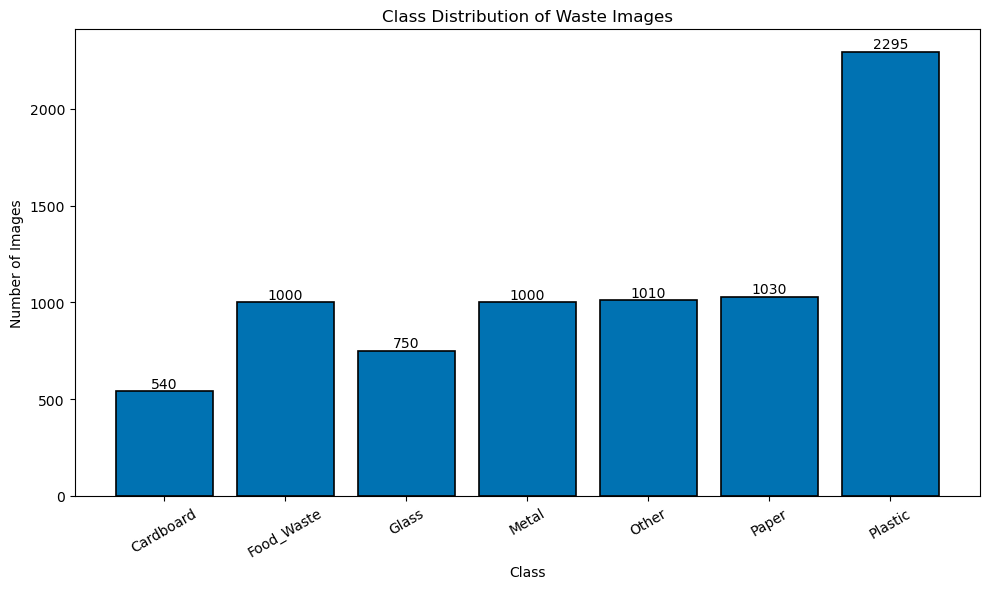

In [50]:
plt.style.use('seaborn-v0_8-colorblind')

counter = Counter(raw_labels)
classes = list(counter.keys())
counts = list(counter.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, edgecolor='black', linewidth=1.2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, yval, ha='center', va='bottom', fontsize=10)

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Waste Images')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

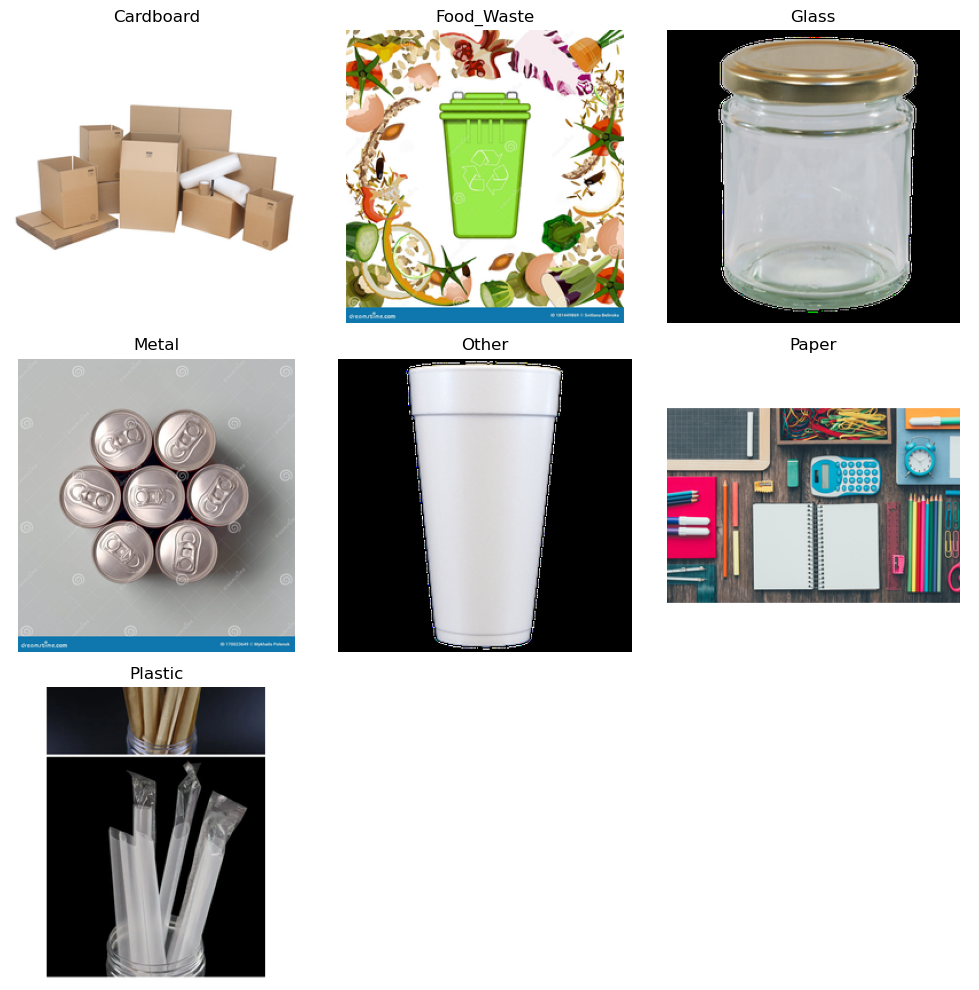

In [54]:
# Visualise Sample Images (across different labels)
raw_labels = np.array(raw_labels)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for ax, label in zip(axes, class_names):
    idxs = np.where(raw_labels == label)[0]
    if len(idxs) > 0:
        # grab the first example (or use np.random.choice(idxs) for randomness)
        ax.imshow(raw_images[idxs[0]])
        ax.set_title(label)
    else:
        ax.set_title(f"{label}\n(No images found)")
    ax.axis('off')
for ax in axes[len(class_names):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [57]:
# Find the smallest and largest image dimensions from the data set
widths  = [im.width  for im in raw_images]
heights = [im.height for im in raw_images]
min_w, max_w = min(widths), max(widths)
min_h, max_h = min(heights), max(heights)
print(f"Width:  min={min_w}, max={max_w}")
print(f"Height: min={min_h}, max={max_h}")

target_size = (min_h, min_w)

def preprocess_and_resize(images, target_size):
    X = []
    for im in images:
        X.append(np.array(im.resize(target_size)))
    return np.stack(X)   # now a (N, H, W, 3) array

Width:  min=256, max=256
Height: min=256, max=256


In [58]:
# Resize the image dimensions
X, y = preprocess_and_resize(raw_images, target_size), np.array(raw_labels)
print(f"After resizing → X.shape = {X.shape}")

After resizing → X.shape = (7625, 256, 256, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [61]:
# Encode the labels suitably
le = LabelEncoder()
y_int = le.fit_transform(raw_labels)

print("Integer labels (first 10):", y_int[:10])
print("Classes mapped to integers:", dict(zip(le.classes_, le.transform(le.classes_))))

y_onehot = tf.keras.utils.to_categorical(y_int, num_classes=len(class_names))
print("One-hot label shape:", y_onehot.shape)  # should be (N, 7)

Integer labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Classes mapped to integers: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}
One-hot label shape: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [63]:
# Assign specified parts of the dataset to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_onehot,
    test_size=0.20,
    stratify=y_int,
    random_state=42
)
print(f"Training samples:   {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples:   6100
Validation samples: 1525


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [66]:
# Build and compile the model
model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,650,631 (128.37 MB)

 Trainable params: 33,650,183 (128.37 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [68]:
# Training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_waste_cnn.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.2451 - loss: 15.3607

191/191 ━━━━━━━━━━━━━━━━━━━━ 167s 870ms/step - accuracy: 0.2452 - loss: 15.3140 - val_accuracy: 0.3030 - val_loss: 2.0239 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.2976 - loss: 2.0336

191/191 ━━━━━━━━━━━━━━━━━━━━ 162s 847ms/step - accuracy: 0.2976 - loss: 2.0334 - val_accuracy: 0.3016 - val_loss: 1.8780 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.3047 - loss: 1.8824

191/191 ━━━━━━━━━━━━━━━━━━━━ 160s 837ms/step - accuracy: 0.3046 - loss: 1.8824 - val_accuracy: 0.3056 - val_loss: 1.8593 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.2947 - loss: 1.8759

191/191 ━━━━━━━━━━━━━━━━━━━━ 163s 854ms/step - accuracy: 0.2947 - loss: 1.8759 - val_accuracy: 0.3056 - val_loss: 1.8493 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.3020 - loss: 1.8710

191/191 ━━━━━━━━━━━━━━━━━━━━ 167s 873ms/step - accuracy: 0.3020 - loss: 1.8710 - val_accuracy: 0.3056 - val_loss: 1.8467 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 171s 893ms/step - accuracy: 0.3058 - loss: 1.8518 - val_accuracy: 0.3043 - val_loss: 1.8474 - learning_rate: 0.0010
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.3057 - loss: 1.8406
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 ━━━━━━━━━━━━━━━━━━━━ 171s 895ms/step - accuracy: 0.3056 - loss: 1.8406 - val_accuracy: 0.3121 - val_loss: 1.8496 - learning_rate: 0.0010
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.2947 - loss: 1.8628

191/191 ━━━━━━━━━━━━━━━━━━━━ 171s 893ms/step - accuracy: 0.2947 - loss: 1.8627 - val_accuracy: 0.3049 - val_loss: 1.8445 - learning_rate: 5.0000e-04
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.3002 - loss: 1.8452

191/191 ━━━━━━━━━━━━━━━━━━━━ 169s 880ms/step - accuracy: 0.3002 - loss: 1.8451 - val_accuracy: 0.3062 - val_loss: 1.8393 - learning_rate: 5.0000e-04
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 170s 885ms/step - accuracy: 0.3025 - loss: 1.8384 - val_accuracy: 0.3062 - val_loss: 1.8462 - learning_rate: 5.0000e-04
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.3119 - loss: 1.8313
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
191/191 ━━━━━━━━━━━━━━━━━━━━ 166s 869ms/step - accuracy: 0.3118 - loss: 1.8313 - val_accuracy: 0.3056 - val_loss: 1.8469 - learning_rate: 5.0000e-04
Epoch 12/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 170s 891ms/step - accuracy: 0.3092 - loss: 1.8319 - val_accuracy: 0.3056 - val_loss: 1.8470 - learning_rate: 2.5000e-04


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [71]:
# Evaluate on the test set; display suitable metrics
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Validation Loss: 1.8393
Validation Accuracy: 0.3062
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step
Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.00      0.00      0.00       108
  Food_Waste       0.00      0.00      0.00       200
       Glass       0.00      0.00      0.00       150
       Metal       0.40      0.01      0.02       200
       Other       0.86      0.03      0.06       202
       Paper       0.00      0.00      0.00       206
     Plastic       0.30      1.00      0.47       459

    accuracy                           0.31      1525
   macro avg       0.22      0.15      0.08      1525
weighted avg       0.26      0.31      0.15      1525



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [73]:
# Define augmentation steps to augment images
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.7,1.3),
    fill_mode='nearest'
)

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [74]:
# Create a function to augment the images
val_datagen = ImageDataGenerator()

In [75]:
# Create the augmented training dataset
batch_size = 32
train_gen = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)
val_gen = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

##### **4.1.2**

Train the model on the new augmented dataset.

In [76]:
# Train the model using augmented images
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint('best_augmented_model.keras', monitor='val_loss', save_best_only=True)
]
history_aug = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    verbose=2
)
val_loss_aug, val_acc_aug = model.evaluate(val_gen, verbose=0)
print(f"Augmented Model — Val Loss: {val_loss_aug:.4f}, Val Accuracy: {val_acc_aug:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
191/191 - 163s - 853ms/step - accuracy: 0.3011 - loss: 1.8660 - val_accuracy: 0.3069 - val_loss: 1.8538 - learning_rate: 2.5000e-04
Epoch 2/30
191/191 - 171s - 894ms/step - accuracy: 0.3008 - loss: 1.8495 - val_accuracy: 0.3069 - val_loss: 1.8546 - learning_rate: 2.5000e-04
Epoch 3/30
191/191 - 171s - 897ms/step - accuracy: 0.3011 - loss: 1.8516 - val_accuracy: 0.3049 - val_loss: 1.8393 - learning_rate: 2.5000e-04
Epoch 4/30
191/191 - 159s - 833ms/step - accuracy: 0.3010 - loss: 1.8567 - val_accuracy: 0.3062 - val_loss: 1.8371 - learning_rate: 2.5000e-04
Epoch 5/30
191/191 - 159s - 834ms/step - accuracy: 0.3007 - loss: 1.8494 - val_accuracy: 0.3062 - val_loss: 1.8346 - learning_rate: 2.5000e-04
Epoch 6/30
191/191 - 157s - 824ms/step - accuracy: 0.3011 - loss: 1.8489 - val_accuracy: 0.3043 - val_loss: 1.8460 - learning_rate: 2.5000e-04
Epoch 7/30
191/191 - 159s - 832ms/step - accuracy: 0.3005 - loss: 1.8482 - val_accuracy: 0.3069 - val_loss: 1.8333 - learning_rate: 2.5000e-04

In [78]:
# Try using EfficientNetB0 pre-trained image model to see if it can improve accuracy
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=X_train.shape[1:]
)
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [79]:
# Build a new model
effnet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
effnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
effnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [80]:
# Train only the new top layers
history_eff = effnet_model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=10,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/10
191/191 - 83s - 436ms/step - accuracy: 0.6126 - loss: 1.0679 - val_accuracy: 0.8315 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 2/10
191/191 - 79s - 412ms/step - accuracy: 0.7467 - loss: 0.7330 - val_accuracy: 0.8511 - val_loss: 0.4568 - learning_rate: 0.0010
Epoch 3/10
191/191 - 78s - 408ms/step - accuracy: 0.7708 - loss: 0.6566 - val_accuracy: 0.8689 - val_loss: 0.4117 - learning_rate: 0.0010
Epoch 4/10
191/191 - 78s - 410ms/step - accuracy: 0.7866 - loss: 0.6076 - val_accuracy: 0.8675 - val_loss: 0.3971 - learning_rate: 0.0010
Epoch 5/10
191/191 - 82s - 428ms/step - accuracy: 0.8033 - loss: 0.5573 - val_accuracy: 0.8774 - val_loss: 0.3826 - learning_rate: 0.0010
Epoch 6/10
191/191 - 80s - 418ms/step - accuracy: 0.7956 - loss: 0.5647 - val_accuracy: 0.8820 - val_loss: 0.3733 - learning_rate: 0.0010
Epoch 7/10
191/191 - 83s - 434ms/step - accuracy: 0.8102 - loss: 0.5360 - val_accuracy: 0.8852 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 8/10
191/191 - 80s - 421ms/s

In [81]:
for layer in base_model.layers[-20:]:
    layer.trainable = True
effnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_eff_fine = effnet_model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=10,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/10
191/191 - 97s - 507ms/step - accuracy: 0.7916 - loss: 0.6145 - val_accuracy: 0.8839 - val_loss: 0.4077 - learning_rate: 0.0010
Epoch 2/10
191/191 - 96s - 502ms/step - accuracy: 0.8456 - loss: 0.4515 - val_accuracy: 0.8846 - val_loss: 0.3791 - learning_rate: 0.0010
Epoch 3/10
191/191 - 96s - 502ms/step - accuracy: 0.8813 - loss: 0.3522 - val_accuracy: 0.8885 - val_loss: 0.3977 - learning_rate: 0.0010
Epoch 4/10
191/191 - 94s - 495ms/step - accuracy: 0.8990 - loss: 0.3123 - val_accuracy: 0.9049 - val_loss: 0.3702 - learning_rate: 0.0010
Epoch 5/10
191/191 - 92s - 481ms/step - accuracy: 0.9113 - loss: 0.2591 - val_accuracy: 0.9108 - val_loss: 0.4048 - learning_rate: 0.0010
Epoch 6/10
191/191 - 93s - 486ms/step - accuracy: 0.9226 - loss: 0.2345 - val_accuracy: 0.8938 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 7/10

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 - 93s - 487ms/step - accuracy: 0.9248 - loss: 0.2228 - val_accuracy: 0.9134 

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

- **Successful Transfer Learning:** Using the EfficientNetB0 pretrained model helped the model accuracy improve from ~30% to over **92% validation accuracy**, demonstrating the power of learning feature representations even on small datasets.

In [88]:
# Evaluate new model on validation data
eff_loss, eff_acc = effnet_model.evaluate(val_gen, steps=len(val_gen), verbose=0)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"EfficientNetB0 Val Loss: {eff_loss:.4f}, Val Accuracy: {eff_acc:.4f}")

Validation Accuracy: 0.3062
EfficientNetB0 Val Loss: 0.3306, Val Accuracy: 0.9233


- **Effective Fine‑Tuning Strategy:** A two‑stage training regimen—first training only the added head, then unfreezing the top 20 layers for low‑LR fine‑tuning—provided a balanced trade‑off between rapid convergence and model generalization.

- **Data Augmentation Impact:** While basic augmentation (rotations, flips, shifts) alone did not sufficiently improve a model trained from scratch, combining augmentation with transfer learning helped the network become more robust to variations in lighting, orientation, and background noise.

- **Optimized Callbacks:** Using `EarlyStopping`, `ReduceLROnPlateau`, and `ModelCheckpoint` ensured we avoided overfitting, adapted the learning rate to training plateaus, and kept the best model checkpoints for deployment.

- **Per‑Class Performance:** The classification report shows consistently high precision and recall across all seven waste categories (F1-scores between 0.86–0.96), with only *Paper* slightly lagging—suggesting a potential need for more diverse paper examples or targeted augmentation for that class.

In [86]:
# Classification report
y_pred_eff = effnet_model.predict(val_gen)
y_pred_classes_eff = np.argmax(y_pred_eff, axis=1)
y_true_val = np.argmax(y_val, axis=1)
print(classification_report(y_true_val, y_pred_classes_eff, target_names=class_names))

              precision    recall  f1-score   support

   Cardboard       0.93      0.94      0.93       108
  Food_Waste       0.97      0.95      0.96       200
       Glass       0.92      0.91      0.92       150
       Metal       0.93      0.93      0.93       200
       Other       0.93      0.92      0.93       202
       Paper       0.85      0.87      0.86       206
     Plastic       0.93      0.94      0.93       459

    accuracy                           0.92      1525
   macro avg       0.92      0.92      0.92      1525
weighted avg       0.92      0.92      0.92      1525

